# Models

This notebook will demonstrate the basic features of AutoMPC for system ID modeling and model evaluation.

## Set-Up

As before, we begin by importing autompc.

In [1]:
import autompc as ampc

Loading AutoMPC...
Finished loading AutoMPC


To perform system identification, we need a dataset of trajectories to work with.  We will use the cartpole system, available from the `benchmarks` package, to generate our dataset.

In [2]:
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

## Models

AutoMPC provides a variety of sytem ID models which can be used to learn the sytem dynamics.  Here, we will use an MLP model, but for a complete list see [here](https://autompc.readthedocs.io/en/latest/source/sysid.html#supported-system-id-models).

There are two ways to create a model: we can either instantiate the model class directly and pass the hyperparameter values to the constructor, or we can use a factory class.  Here we will use the first method, but for more information on using model factories, see [4. Factories and Pipelines](https://github.com/williamedwards/autompc/tree/main/examples). (**Note:** This will take several minutes to run depending on your hardware).

In [3]:
from autompc.sysid import MLP

model = MLP(system, n_hidden_layers=2, hidden_size_1=128, hidden_size_2=128, n_train_iters=50,
               nonlintype="relu")

model.train(trajs)

MLP Using Cuda
hidden_sizes= [128, 128]
100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


Now that we have trained our model, we can use it to make predictions.  Let's try predicting the next state from one of our training trajectories.  We first compute the model state at a certain point in the trajectory

In [4]:
traj = trajs[0]
model_state = model.traj_to_state(traj[:100])

The model state contains the information the model needs to predict the next time step.  `model_state[:system.obs_dim]` is always equal to the most recent observation.  For the MLP, that's actually all there is to the model state, but some models require a larger state.  We can see the dimension of the model state by running

In [5]:
model.state_dim

4

We can also check other properties of the model, such as whether it is differentiable and whether it is linear.

In [6]:
print("Model is Differentiable? ", model.is_diff)
print("Model is Linear? ", model.is_linear)

Model is Differentiable?  True
Model is Linear?  False


For comparison, consider the ARX model.  We observe that, unlike the MLP model, the ARX model state size is larger than `system.obs_dim` since the model state includes the history of several observations.  Make sure to use the `traj_to_state` method to properly derive the model state.  We can also observe that the ARX model is linear, which means that it is suitable for use with LQR control.

In [7]:
from autompc.sysid import ARX

model_arx = ARX(system, history=4)
model_arx.train(trajs)

In [8]:
model_state_arx = model.traj_to_state(traj[:100])
model_arx.state_dim

20

In [9]:
model_arx.is_linear

True

We can use our current model state, and the control to make a prediction of the new model state

In [10]:
pred_state = model.pred(model_state, traj[99].ctrl)
pred_state

array([  2.68904848,   4.34388929, -18.87875015,  -1.47925303])

Compare this to the true observation

In [11]:
traj[100].obs

array([  2.6883774 ,   4.35962019, -18.88053395,  -1.48034168])

We can use the true observation to update our model state

In [12]:
new_model_state = model.update_state(model_state, traj[99].ctrl, traj[100].obs)
new_model_state

array([  2.6883774 ,   4.35962019, -18.88053395,  -1.48034168])

For differentiable models, we can also get the Jacobian of the
model prediction

In [13]:
pred_state, state_jac, ctrl_jac = model.pred_diff(model_state, traj[99].ctrl)
state_jac

array([[ 9.99461821e-01,  5.00246965e-02,  2.09341493e-06,
         3.14312251e-05],
       [ 3.08593706e-01,  9.50024915e-01, -1.36170382e-04,
         4.72344764e-04],
       [ 1.72465719e-03,  9.48241781e-05,  1.00000052e+00,
         5.00611682e-02],
       [-1.46301363e-03, -4.05346239e-04,  1.09951194e-05,
         1.00022062e+00]])

## Graphing Model Accuracy

Let's train another, much smaller MLP model

In [14]:
from autompc.sysid import MLP

model2 = MLP(system, n_hidden_layers=1, hidden_size_1=32, n_train_iters=50,
               nonlintype="relu")

model2.train(trajs)

MLP Using Cuda
hidden_sizes= [32]
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


Now, we'd like to compare this to our original model.  One convenient way to do this is by graphing the model prediction horizon over various prediction horizons.  AutoMPC provides tools for easily constructing this graph.  (**Note:** This may take a few minutes to run)

/usr/lib/python3/dist-packages/pyparsing.py:1745: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


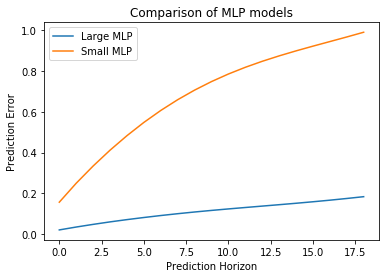

In [15]:
import matplotlib.pyplot as plt
from autompc.graphs.kstep_graph import KstepPredAccGraph

graph = KstepPredAccGraph(system, trajs, kmax=20, metric="rmse")
graph.add_model(model, "Large MLP")
graph.add_model(model2, "Small MLP")

fig = plt.figure()
ax = fig.gca()
graph(fig, ax)
ax.set_title("Comparison of MLP models")
plt.show()

We can see that the small MLP has a larger prediction error at all time steps and its prediction error increases more rapidly over longer prediction horizons.